In [4]:
import HCLcat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### The function `generate_noise_curve(snr)` generate a nouse curve with __Signal to Noise ratio__ (SNR) = `snr`:

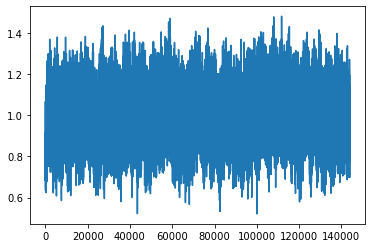

In [31]:
y = HCLcat.generate_noise_curve(snr=10)
HCLcat.calculate_snr(y)
plt.plot(y)

### The default length is 144,000, but you can choose with the `lenght` parameter:

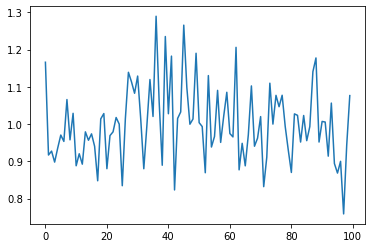

In [32]:
y = HCLcat.generate_noise_curve(snr=10, lenght=100)
HCLcat.calculate_snr(y)
plt.plot(y)

### Examples of High Cadence Noise filtering tools

First, we download the data we need, this light curve was taken in the 84cm telescope in the Observatorio Astronómico Nacional in San Pedro Martir (OAN-SPM).

Some additional info:

- **Target**: [Hat-p-37b](http://exoplanet.eu/catalog/hat-p-37_b/)
- **Observation date**: 07-Aug-2016
- **Detector**: iXon Ultra 888
- **Binning**: 3x3
- **Method**: Aperture photometry
- **Observer**: Fernando Alvarez


In [21]:
url="https://raw.githubusercontent.com/ferwazz/master_tesis/develop/data/hatp37_7ago.out"
lc_hat37b=pd.read_csv(url,names=["NormalizedFlux"])

In TAOS II we expect 2-hour light curves:

In [22]:
hat37b_2hour = lc_hat37b["NormalizedFlux"].iloc[50000:194000] #Only the start of the transit

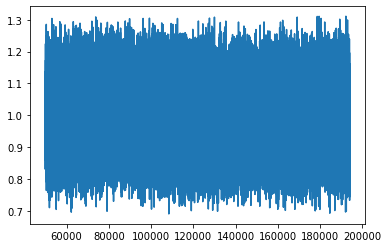

In [23]:
plt.plot(hat37b_2hour)

### Fourier filter:

You can apply Low-Pass Fourier Filter using `fourierfilter`, the cutoff frequency is `cutfreq`

In [24]:
hatp37b_fourier_filtered = HCLcat.fourierfilter(hat37b_2hour, cutfreq=0.002)

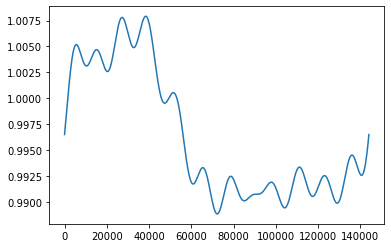

In [26]:
plt.plot(hatp37b_fourier_filtered[1:])

### Moving average:

You can apply Moving average filter `prom_mov`, the `mov` indicates the numbers of samples to average. If `med=True` perform median instead of mean.

In [27]:
hatp37b_mov_filtered = HCLcat.prom_mov(hat37b_2hour, mov=2000, med=True)

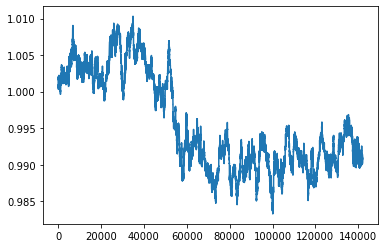

In [28]:
plt.plot(hatp37b_mov_filtered)

### PCA Filter

In [5]:
import batman
import h5py

First, we need a database to calculate the principal components, this database contains simuated transit lights curves using `batman`. We store the database in hdf5 format for later filtering

In [15]:
f = h5py.File('train_pca_mandel.hdf5', 'w')
save_weights_only=True
radius=5
tc=5
radiusratio=np.logspace(-1.650514998,-0.650514998,radius)
plt.figure(1)
for j in np.arange(tc)+1:
    for i in range(radius):
        params = batman.TransitParams()
        params.t0 = 0.                       #time of inferior conjunction
        params.per = 2*((3.5*j)/tc)          #orbital period
        params.rp = radiusratio[i]           #planet radius (in units of stellar radii)
        params.a = 15                        #semi-major axis (in units of stellar radii)
        params.inc = 90.                     #orbital inclination (in degrees)
        params.ecc = 0.                      #eccentricity
        params.w = 90.                       #longitude of periastron (in degrees)
        params.u = [0.1, 0.3]                #limb darkening coefficients
        params.limb_dark = "quadratic"       #limb darkening mode CAMBIAR A LINEAL
        t = np.linspace(-0.15,0,144000)
        m = batman.TransitModel(params, t)    #initializes model
        flux= m.light_curve(params)          #calculates light curve
        mask = (flux < 1)
        tcaida=(mask.sum())/(20*60)
        dset2 = f.create_dataset("transito_rp_{:.3f}_tc_{:.3f}".format(radiusratio[i],tcaida),data=flux)
f.close()

<Figure size 432x288 with 0 Axes>

In [19]:
#####LEYENDO DATA PARA ENTRENAR PCA
f=h5py.File('train_pca_mandel.hdf5', 'r')
i=0
data_train=np.zeros((144000,len(f.keys())))
for key in f.keys():
    data_train[:,i] = np.array(f[key])
    i=i+1
comp_entradas=HCLcat.pca_train(data_train)
comp_salidas=HCLcat.pca_train(data_train[::-1])
f.close()

In [29]:
hatp37b_pca_filtered=HCLcat.pca_filter(hat37b_2hour, comp_entradas)

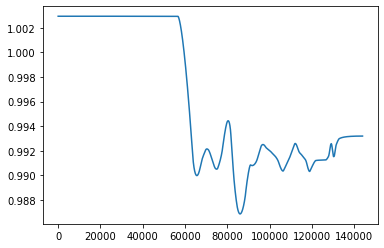

In [30]:
plt.plot(hatp37b_pca_filtered)

### Visualizing and comparing curves

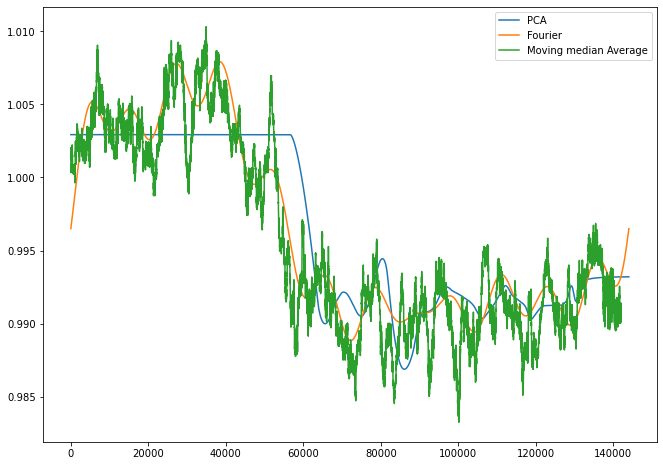

In [34]:
plt.figure(figsize=(11,8))
plt.plot(hatp37b_pca_filtered, label ="PCA")
plt.plot(hatp37b_fourier_filtered[1:], label ="Fourier")
plt.plot(hatp37b_mov_filtered, label ="Moving median Average")
plt.legend()